In [3]:
import os
import tqdm
import datasets
import traceback
from datasets import Dataset, Audio, load_dataset
from transformers import WhisperFeatureExtractor, AutoTokenizer
import logging

parquets_path = '/mnt/datasets/librispeech_asr/all/test.clean'

In [4]:
train_files = os.listdir(parquets_path)
print(f"len(train_files): {len(train_files)}")

len(train_files): 1


In [5]:
batch_size=10
error_batchs=[]
for i in tqdm.tqdm(range(0, len(train_files), batch_size)):
    batch = train_files[i:i+batch_size]
    batch = [os.path.join(parquets_path,file) for file in batch]
    print(batch)
    tmp_dataset = load_dataset("parquet", data_files=batch, split='train', cache_dir='/mnt/.cache/')
    break

  0%|          | 0/1 [00:00<?, ?it/s]

['/mnt/datasets/librispeech_asr/all/test.clean/0000.parquet']


  0%|          | 0/1 [00:00<?, ?it/s]


In [6]:
tmp_dataset = tmp_dataset.cast_column("audio", Audio(sampling_rate=16000))

In [7]:
a = tmp_dataset['audio']
a = [i['array'] for i in a]
t = tmp_dataset['text']

In [8]:
import numpy as np
a = [np.array(i*32768,dtype=np.int16) for i in a][:2]   #取俩样本
t = t[:2]

In [ ]:
print(a , a.shape)

print(t)

([array([  -2,    3,   35, ...,  -72, -373, -289], dtype=int16),
  array([-187, -240,  168, ...,   28,   23,   22], dtype=int16)],
 ['CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS',
  'THE ENGLISH FORWARDED TO THE FRENCH BASKETS OF FLOWERS OF WHICH THEY HAD MADE A PLENTIFUL PROVISION TO GREET THE ARRIVAL OF THE YOUNG PRINCESS THE FRENCH IN RETURN INVITED THE ENGLISH TO A SUPPER WHICH WAS TO BE GIVEN THE NEXT DAY'])

In [2]:
from efficient_layer_wise_conformer import LoadConformerEncoder, EfficientLayerWiseSteeringConformerEncoder,SteerMoEEfficientLayerWiseModelForConformer
from conformer_module.asr_feat import ASRFeatExtractor
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback, TrainerCallback, WhisperFeatureExtractor
import os
# from models import SteerMoEEfficientLayerWiseModelForConformer
llm_path = "/mnt/models/Qwen2.5-7B-Instruct/"
model_path = "/mnt/models/FireRedASR-LLM-L"
# f_encoder = EfficientLayerWiseSteeringConformerEncoder(model_path+"/asr_encoder.pth.tar")
cmvn_path = os.path.join(model_path, "cmvn.ark")   ###TODO!!!! ADD conformer_model_dir TO YAML 
feature_extractor = ASRFeatExtractor(cmvn_path)

print("Loading LLM decoder...")
llm_decoder = AutoModelForCausalLM.from_pretrained(llm_path)
llm_decoder.eval()
for p in llm_decoder.parameters():
    p.requires_grad = False

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(llm_path)


model = SteerMoEEfficientLayerWiseModelForConformer(
    conformer_encoder_path=model_path+"/asr_encoder.pth.tar",
    llm_decoder=llm_decoder,
    max_prompt_tokens=2048,

)

Loading LLM decoder...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading tokenizer...


/root/SteerMoE/steer_moe/efficient_layer_wise_conformer.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  package = torch.load(model_path, map_location=lambda storage, lo

In [14]:
model.conformer_encoder

EfficientLayerWiseSteeringConformerEncoder(
  (original_encoder): LoadConformerEncoder(
    (speech_encoder): ConformerEncoder(
      (input_preprocessor): Conv2dSubsampling(
        (conv): Sequential(
          (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
          (1): ReLU()
          (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
          (3): ReLU()
        )
        (out): Linear(in_features=608, out_features=1280, bias=True)
      )
      (positional_encoding): RelPositionalEncoding()
      (dropout): Dropout(p=0.1, inplace=False)
      (layer_stack): ModuleList(
        (0-15): 16 x RelPosEmbConformerBlock(
          (ffn1): ConformerFeedForward(
            (net): Sequential(
              (0): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
              (1): Linear(in_features=1280, out_features=5120, bias=True)
              (2): Swish()
              (3): Dropout(p=0.1, inplace=False)
              (4): Linear(in_features=5120, out_features=1280, 

In [10]:
# f_encoder.original_encoder.config["d_model"]

In [11]:
feat_pad,lenth,_ = feature_extractor(a)

In [12]:
feat_pad,feat_pad.shape,feat_pad.dtype,lenth.shape,lenth.dtype

(tensor([[[-0.2856, -0.4197, -1.1607,  ..., -0.9456, -0.8772, -0.5609],
          [-0.8424, -1.2985, -1.1284,  ..., -0.7610, -0.6623, -0.4552],
          [-0.9534, -0.8566, -1.5514,  ..., -0.8114, -0.7233, -0.6335],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 0.2127, -0.0260, -0.7086,  ...,  0.1921,  0.1618, -0.1614],
          [ 0.1598, -0.0907, -0.6142,  ...,  0.1974, -0.0103, -0.1176],
          [ 0.2909,  0.0104, -0.8412,  ...,  0.0110,  0.1687,  0.1733],
          ...,
          [ 0.3736,  0.2121, -0.5753,  ..., -0.8886, -0.7748, -0.6435],
          [-0.1102, -0.3319, -1.5786,  ..., -0.8393, -0.5610, -0.6895],
          [-0.0847, -0.3198, -1.8303,  ..., -1.1842, -0.8237, -0.7426]]]),
 torch.Size([2, 1421, 80]),
 torch.float32,
 torch.Size([2]),
 torch.int64)

In [13]:
# tensor_forward = f_encoder._forward_with_steering(feat_pad[0:2],lenth[0:2])
# tensor_forward.dtype,tensor_forward.shape

In [14]:
import torch
text_tokens = tokenizer(t)
labels = text_tokens['input_ids']
eos_token_id = tokenizer.eos_token_id
if eos_token_id is None:
    raise ValueError("Tokenizer must have an EOS token ID.")
eos_tensor = torch.tensor([eos_token_id], dtype=torch.long)
textual_prompt = "this is a test"
eos_tensor

tensor([151645])

In [15]:
max_length = 2048
l = []
decoder_input_ids = []
for label_ids in labels:
    if isinstance(label_ids, torch.Tensor):
        label_ids = label_ids.squeeze()
    else:
        label_ids = torch.tensor(label_ids, dtype=torch.long).squeeze()
    if isinstance(label_ids, torch.Tensor):
        # Remove padding tokens (-100 and pad_token_id)
        valid_mask = (label_ids != -100) & (label_ids != tokenizer.pad_token_id)
        if valid_mask.any():
            clean_labels = label_ids[valid_mask]
        else:
            clean_labels = torch.tensor([], dtype=torch.long)
    else:
        clean_labels = torch.tensor(label_ids, dtype=torch.long)
    clean_labels_with_eos = torch.cat([clean_labels, eos_tensor])
    prompt_tokens = tokenizer.encode(
                    textual_prompt, 
                    add_special_tokens=False,
                    return_tensors="pt"
                ).squeeze(0)
    decoder_input = torch.cat([prompt_tokens, clean_labels_with_eos])
    empty_prompt = torch.full_like(prompt_tokens, fill_value=-100)
    label = torch.cat([empty_prompt, clean_labels_with_eos])
    
    if decoder_input.numel() > 0 and decoder_input.size(0) > max_length:
        decoder_input = decoder_input[: max_length]
    if label.numel() > 0 and label.size(0) > max_length:
        label = label[: max_length]
    decoder_input_ids.append(decoder_input)
    l.append(label)


label_features=[{"input_ids": input_ids} for input_ids in l]
if label_features:
    # labels_batch = self.tokenizer.pad(label_features, return_tensors="pt")
    labels_batch = tokenizer.pad(
        label_features, 
        return_tensors="pt",
        # padding_value=-100,
        max_length=max_length,
        padding="max_length",
        # truncation=True,
    )
    batch_labels = labels_batch["input_ids"]
    batch_labels = batch_labels.masked_fill(labels_batch.attention_mask.ne(1), -100)
input_features=[{"input_ids": input_ids} for input_ids in decoder_input_ids]
if label_features:
    # input_ids_batch = self.tokenizer.pad(input_features, return_tensors="pt")
    input_ids_batch = tokenizer.pad(
        input_features, 
        return_tensors="pt",
        # padding_value=-100,
        max_length=max_length,
        padding="max_length",
        # truncation=True,
    )
    # logging.debug(f"input_ids_batch: {input_ids_batch}")
    # logging.debug(f"input_ids_batch['input_ids']: {input_ids_batch['input_ids'].shape}, {input_ids_batch['input_ids'].dtype}, {input_ids_batch['input_ids']}")
    # logging.debug(f"input_ids_batch['attention_mask']: {input_ids_batch['attention_mask'].shape}, {input_ids_batch['attention_mask'].dtype}, {input_ids_batch['attention_mask']}")

    batch_input_ids = input_ids_batch["input_ids"]


You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [16]:
batch_input_ids.shape,batch_labels.shape,batch_input_ids.dtype,batch_labels.dtype

(torch.Size([2, 2048]), torch.Size([2, 2048]), torch.int64, torch.int64)

In [29]:
batch_labels[1][:80],batch_input_ids[1][:80],batch_labels[0][:20],batch_input_ids[0][:20]

(tensor([  -100,   -100,   -100,   -100,  17229,   5190,  64418,   4613,  97709,
           5146,   3168,    434,  40892,   2149,    425,   7384,  43167,   3008,
            434,   9441,   4321,   3008,  78164,  62493,    472,   1808,  78699,
            362,    393,    867,   6408,   2773,   1094,   5308,  47671,   5146,
            479,  55921,   3168,  82079,  90493,   3008,   3168,    809,   5044,
             38,   8575,    687,   5246,   3168,    434,  40892,   2149,   1964,
          30880,  66924,  78504,   3168,   5190,  64418,   5146,    362,  53622,
           9654,  78164,  37776,   5146,   7206,  89836,   3168,  45011,  37688,
         151645,   -100,   -100,   -100,   -100,   -100,   -100,   -100]),
 tensor([   574,    374,    264,   1273,  17229,   5190,  64418,   4613,  97709,
           5146,   3168,    434,  40892,   2149,    425,   7384,  43167,   3008,
            434,   9441,   4321,   3008,  78164,  62493,    472,   1808,  78699,
            362,    393,    867,  

In [30]:
if hasattr(llm_decoder, 'model') and hasattr(llm_decoder.model, 'embed_tokens'):
    # LLaMA-like decoder (Qwen, LLaMA, etc.)
    text_embeds = llm_decoder.model.embed_tokens(batch_input_ids)
elif hasattr(llm_decoder, 'transformer') and hasattr(llm_decoder.transformer, 'wte'):
    # GPT-2 like decoder
    text_embeds = llm_decoder.transformer.wte(batch_input_ids)
elif hasattr(llm_decoder, 'get_input_embeddings'):
    # Generic approach
    text_embeds = llm_decoder.get_input_embeddings()(batch_input_ids)
else:
    raise ValueError("Could not find embedding method for decoder. Please adapt for your LLM.")
text_embeds.shape,text_embeds.dtype

(torch.Size([2, 2048, 3584]), torch.float32)

In [31]:
text_embeds

tensor([[[-0.0233, -0.0286,  0.0486,  ..., -0.0104, -0.0315, -0.0240],
         [ 0.0227, -0.0030,  0.0099,  ..., -0.0118, -0.0026, -0.0010],
         [ 0.0021, -0.0151, -0.0015,  ..., -0.0120, -0.0090,  0.0060],
         ...,
         [-0.0186,  0.0347,  0.0092,  ...,  0.0040, -0.0077,  0.0006],
         [-0.0186,  0.0347,  0.0092,  ...,  0.0040, -0.0077,  0.0006],
         [-0.0186,  0.0347,  0.0092,  ...,  0.0040, -0.0077,  0.0006]],

        [[-0.0233, -0.0286,  0.0486,  ..., -0.0104, -0.0315, -0.0240],
         [ 0.0227, -0.0030,  0.0099,  ..., -0.0118, -0.0026, -0.0010],
         [ 0.0021, -0.0151, -0.0015,  ..., -0.0120, -0.0090,  0.0060],
         ...,
         [-0.0186,  0.0347,  0.0092,  ...,  0.0040, -0.0077,  0.0006],
         [-0.0186,  0.0347,  0.0092,  ...,  0.0040, -0.0077,  0.0006],
         [-0.0186,  0.0347,  0.0092,  ...,  0.0040, -0.0077,  0.0006]]])

In [36]:
output = model.forward(input_features=feat_pad,input_lengths=lenth,decoder_input_ids=batch_input_ids ,labels=batch_labels)

torch.Size([2, 356, 1280])
torch.Size([2, 356, 1280])
torch.Size([2, 356, 1280])
torch.Size([2, 356, 1280])
torch.Size([2, 356, 1280])
torch.Size([2, 356, 1280])
torch.Size([2, 356, 1280])
torch.Size([2, 356, 1280])
torch.Size([2, 356, 1280])
torch.Size([2, 356, 1280])
torch.Size([2, 356, 1280])
torch.Size([2, 356, 1280])
torch.Size([2, 356, 1280])
torch.Size([2, 356, 1280])
torch.Size([2, 356, 1280])
torch.Size([2, 356, 1280])


In [37]:
output

CausalLMOutputWithPast(loss=tensor(4.4081, grad_fn=<NllLossBackward0>), logits=tensor([[[ 3.4813, -0.2084,  7.9926,  ..., -2.4326, -2.4325, -2.4326],
         [-0.1394, -0.6840,  4.4496,  ..., -1.7007, -1.7009, -1.7007],
         [-3.7897, -6.5365,  2.5070,  ..., -1.0642, -1.0643, -1.0642],
         ...,
         [ 5.9601,  4.4539,  7.6285,  ..., -7.7703, -7.7700, -7.7702],
         [ 5.9326,  4.4265,  7.5595,  ..., -7.8098, -7.8095, -7.8097],
         [ 5.8897,  4.4176,  7.5241,  ..., -7.9004, -7.9001, -7.9003]],

        [[ 4.7720,  1.9469,  5.3094,  ..., -2.2008, -2.2006, -2.2010],
         [ 4.2119,  2.1996,  5.6233,  ..., -2.5362, -2.5361, -2.5366],
         [ 3.7612,  2.4094,  6.8012,  ..., -2.1469, -2.1469, -2.1471],
         ...,
         [ 8.1055,  4.6249,  9.6407,  ..., -4.9379, -4.9376, -4.9378],
         [ 7.9674,  4.6644,  9.5916,  ..., -5.1354, -5.1351, -5.1353],
         [ 8.0399,  4.6638,  9.6140,  ..., -5.0374, -5.0372, -5.0374]]],
       grad_fn=<UnsafeViewBackward0>)

In [1]:
from datasets import  concatenate_datasets, DatasetDict, load_from_disk
from typing import Dict, List, Optional, Tuple
import os
import tqdm

def load_parquet_datasets_for_steermoe(parquet_dirs: List[str]) -> DatasetDict:
    """Load and concatenate datasets from parquet directories."""
    print('Loading datasets...')
    dataset = DatasetDict()
    train_datasets = []

    for folder in tqdm.tqdm(parquet_dirs):
        tmp = load_from_disk(folder)
        train_datasets.append(tmp)

    concat = train_datasets[0]
    for tmp_dataset in tqdm.tqdm(train_datasets[1:]):
        concat = concatenate_datasets([concat, tmp_dataset])

    dataset['train'] = concat
    print(f"Total samples: {len(concat)}")
    return dataset

expanded_dirs = []
parquet_dirs = [ "/mnt/processed_datasets/librispeech_asr_for_conformer/train.clean.100/", "/mnt/processed_datasets/librispeech_asr_for_conformer/train.clean.360/"]
for parquet_dir in parquet_dirs:
    if os.path.isdir(parquet_dir):
        subdirs = [os.path.join(parquet_dir, d) for d in os.listdir(parquet_dir) 
                    if os.path.isdir(os.path.join(parquet_dir, d))]
        if subdirs:
            expanded_dirs.extend(subdirs)
        else:
            expanded_dirs.append(parquet_dir)
    else:
        expanded_dirs.append(parquet_dir)

dataset = load_parquet_datasets_for_steermoe(expanded_dirs)
print(f"Dataset: {type(dataset)} {dataset}")

Loading datasets...


  0%|          | 0/7 [00:00<?, ?it/s]/mnt/envs/rt_mo/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
100%|██████████| 6/6 [00:00<00:00, 87.77it/s]

Total samples: 132553
Dataset: <class 'datasets.dataset_dict.DatasetDict'> DatasetDict({
    train: Dataset({
        features: ['text', 'input_length', 'input_features', 'labels', 'attention_mask', 'sample_rate'],
        num_rows: 132553
    })
})


In [2]:

import pandas as pd

def analyze_with_pandas_describe(data_list):
  """
  使用 pandas.Series.describe() 快速生成统计摘要。
  """
  if not isinstance(data_list, list) or not data_list:
    return "输入错误：提供的数据必须是一个非空的列表。"

  try:
    s = pd.Series(data_list)
    return s.describe()
  except Exception as e:
    return f"发生错误: {e}"

summary = analyze_with_pandas_describe(dataset['train']['input_length'])

print("使用 Pandas.describe() 的分析结果:")
print(summary)
        

使用 Pandas.describe() 的分析结果:
count    132553.000000
mean         12.607088
std           3.619057
min           1.065000
25%          11.435000
50%          13.945000
75%          15.145000
max          29.735000
dtype: float64


/mnt/envs/rt_mo/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/envs/rt_mo/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


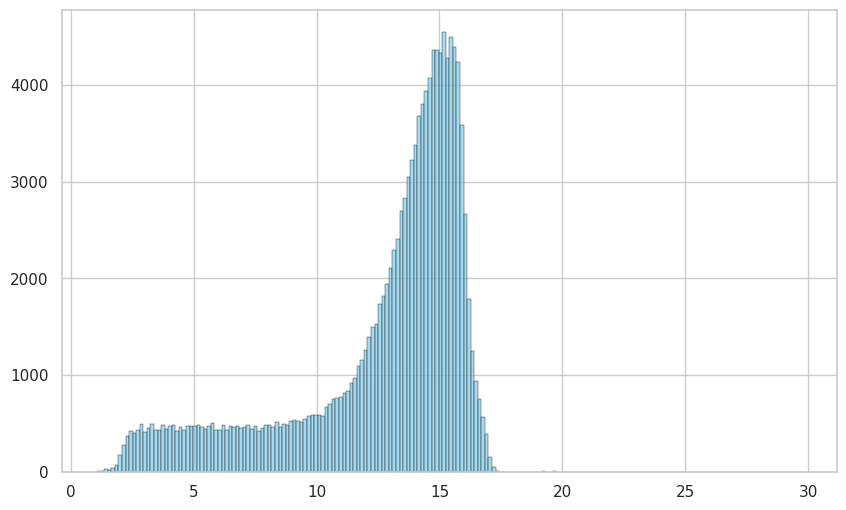

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histogram(data_list, bins='auto', title='', xlabel='', ylabel=''):
  """
  为浮点数列表绘制一个标准的直方图。

  参数:
    data_list (list): 包含数字的列表。
    bins (int or str): 直方图的箱子数量。默认为'auto'，算法会自动选择。
    title (str): 图形标题。
    xlabel (str): x轴标签。
    ylabel (str): y轴标签。
  """
  if not isinstance(data_list, list) or not data_list:
    print("输入错误：提供的数据必须是一个非空的列表。")
    return

  # 设置绘图风格
  sns.set_theme(style="whitegrid")
  plt.figure(figsize=(10, 6))

  # 使用 Seaborn 绘图，它能提供更美观的默认样式
  sns.histplot(data=data_list, bins=bins, color='skyblue', edgecolor='black')

  # 设置标题和标签
  plt.title(title, fontsize=16)
  plt.xlabel(xlabel, fontsize=12)
  plt.ylabel(ylabel, fontsize=12)

  # 显示图形
  plt.show()
plot_histogram(dataset['train']['input_length'])

In [4]:

lengths = dataset['train']['input_length']
count = 0 
re = []
for i in lengths:
    if i >=29:
        re.append(count)
    count +=1
re

[128946]

In [5]:
len(dataset['train'][128946]['input_features']),len(dataset['train'][128947]['input_features'])

(475760, 188960)

In [6]:
import numpy as np
a = [np.array(dataset['train'][128946]['input_features'],dtype=np.int16),np.array(dataset['train'][128946]['input_features'],dtype=np.int16)]
t = [dataset['train'][128946]['text'],dataset['train'][128946]['text']]
a,t


([array([ 8, 13,  8, ...,  9,  8, 12], dtype=int16),
  array([ 8, 13,  8, ...,  9,  8, 12], dtype=int16)],
 ['IT WILL BE FORCED TO DEVELOP THE AUTONOMY OF ITS RATIONAL MIDDLE CLASS IN THE STRUGGLES THAT WILL RENDER THESE COMPROMISES POSSIBLE AND IT WILL BE FINALLY NOT IMPERIAL GERMAN IDEAS BUT CENTRAL EUROPEAN IDEAS POSSIBLY MORE AKIN TO SWISS CONCEPTIONS A CIVILIZED REPUBLICANISM FINDING ITS CLEAREST EXPRESSION IN THE FRENCH LANGUAGE THAT WILL BE ESTABLISHED UPON A BILINGUAL BASIS THROUGHOUT WESTERN EUROPE AND INCREASINGLY PREDOMINANT OVER THE WHOLE EUROPEAN MAINLAND AND THE MEDITERRANEAN BASIN AS THE TWENTIETH CENTURY CLOSES',
  'IT WILL BE FORCED TO DEVELOP THE AUTONOMY OF ITS RATIONAL MIDDLE CLASS IN THE STRUGGLES THAT WILL RENDER THESE COMPROMISES POSSIBLE AND IT WILL BE FINALLY NOT IMPERIAL GERMAN IDEAS BUT CENTRAL EUROPEAN IDEAS POSSIBLY MORE AKIN TO SWISS CONCEPTIONS A CIVILIZED REPUBLICANISM FINDING ITS CLEAREST EXPRESSION IN THE FRENCH LANGUAGE THAT WILL BE ESTABLISHED UPON A

In [7]:
from efficient_layer_wise_conformer import LoadConformerEncoder, EfficientLayerWiseSteeringConformerEncoder,SteerMoEEfficientLayerWiseModelForConformer
from conformer_module.asr_feat import ASRFeatExtractor
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback, TrainerCallback, WhisperFeatureExtractor
# from models import SteerMoEEfficientLayerWiseModelForConformer
llm_path = "/mnt/models/Qwen2.5-7B-Instruct/"
model_path = "/mnt/models/FireRedASR-LLM-L"
# f_encoder = EfficientLayerWiseSteeringConformerEncoder(model_path+"/asr_encoder.pth.tar")
cmvn_path = os.path.join(model_path, "cmvn.ark")   ###TODO!!!! ADD conformer_model_dir TO YAML 
feature_extractor = ASRFeatExtractor(cmvn_path)

print("Loading LLM decoder...")
llm_decoder = AutoModelForCausalLM.from_pretrained(llm_path)
llm_decoder.eval()
for p in llm_decoder.parameters():
    p.requires_grad = False

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(llm_path)


model = SteerMoEEfficientLayerWiseModelForConformer(
    conformer_encoder_path=model_path+"/asr_encoder.pth.tar",
    llm_decoder=llm_decoder,
    max_prompt_tokens=2048,

)

Loading LLM decoder...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading tokenizer...


/root/SteerMoE/steer_moe/efficient_layer_wise_conformer.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  package = torch.load(model_path, map_location=lambda storage, lo

In [8]:
feat_pad,lenth,_ = feature_extractor(a)

In [9]:
feat_pad.size(),lenth

(torch.Size([2, 3000, 80]), tensor([2972, 2972]))

In [ ]:
feat_pad

tensor([[[-1.4999, -1.2471, -1.3419,  ..., -1.4947, -1.3790, -1.0137],
         [-1.4325, -1.3568, -1.8447,  ..., -1.3733, -1.2740, -1.1538],
         [-1.6582, -1.8560, -1.6742,  ..., -1.3952, -1.3707, -1.0863],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-1.4999, -1.2471, -1.3419,  ..., -1.4947, -1.3790, -1.0137],
         [-1.4325, -1.3568, -1.8447,  ..., -1.3733, -1.2740, -1.1538],
         [-1.6582, -1.8560, -1.6742,  ..., -1.3952, -1.3707, -1.0863],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]])

In [11]:
import torch.nn.functional as F
speech_encoder = model.conformer_encoder.original_encoder.speech_encoder
speech_encoder.eval()
feat_pad = F.pad(feat_pad,
    (0, 0, 0, speech_encoder.input_preprocessor.context - 1), 'constant', 0.0)
src_mask = speech_encoder.padding_position_is_0(feat_pad, lenth)

feat_pad.shape,src_mask.shape

(torch.Size([2, 3006, 80]), torch.Size([2, 1, 3006]))

In [12]:
import torch
feat_pad[0][2972:] = torch.ones_like(feat_pad[0][2972:])
feat_pad

tensor([[[-1.4999, -1.2471, -1.3419,  ..., -1.4947, -1.3790, -1.0137],
         [-1.4325, -1.3568, -1.8447,  ..., -1.3733, -1.2740, -1.1538],
         [-1.6582, -1.8560, -1.6742,  ..., -1.3952, -1.3707, -1.0863],
         ...,
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],

        [[-1.4999, -1.2471, -1.3419,  ..., -1.4947, -1.3790, -1.0137],
         [-1.4325, -1.3568, -1.8447,  ..., -1.3733, -1.2740, -1.1538],
         [-1.6582, -1.8560, -1.6742,  ..., -1.3952, -1.3707, -1.0863],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]])

In [13]:
x, input_lengths, src_mask = speech_encoder.input_preprocessor(feat_pad, src_mask)
enc_output = speech_encoder.dropout(x)
pos_emb = speech_encoder.positional_encoding(x)
pos_emb = speech_encoder.dropout(pos_emb)
enc_output.shape,input_lengths,src_mask

(torch.Size([2, 750, 1280]),
 tensor([743, 743]),
 tensor([[[1, 1, 1,  ..., 0, 0, 0]],
 
         [[1, 1, 1,  ..., 0, 0, 0]]], dtype=torch.uint8))

In [14]:
src_mask[0]

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1

In [15]:
layer_output = speech_encoder.layer_stack[0](x, pos_emb, slf_attn_mask=src_mask,
                        pad_mask=src_mask)

router_output = model.conformer_encoder.router(layer_output)
layer_output.shape,router_output.shape

(torch.Size([2, 750, 1280]), torch.Size([2, 750, 128]))

In [16]:
x[0][740:],x[1][740:]

(tensor([[ 0.2433, -0.1482,  0.3339,  ..., -0.3631, -0.1195, -0.0708],
         [ 0.2924, -0.0353,  0.3296,  ..., -0.3043, -0.0314, -0.1334],
         [ 0.1040, -0.1029,  0.2080,  ...,  0.0290,  0.0925, -0.2431],
         ...,
         [-0.0688,  0.1483,  0.1046,  ...,  0.0111, -0.0706, -0.0542],
         [-0.0688,  0.1483,  0.1046,  ...,  0.0111, -0.0706, -0.0542],
         [-0.0688,  0.1483,  0.1046,  ...,  0.0111, -0.0706, -0.0542]]),
 tensor([[ 0.2433, -0.1482,  0.3339,  ..., -0.3631, -0.1195, -0.0708],
         [ 0.2924, -0.0353,  0.3296,  ..., -0.3043, -0.0314, -0.1334],
         [ 0.1957, -0.0585,  0.2418,  ..., -0.1430,  0.0797, -0.1236],
         ...,
         [ 0.0628,  0.0151,  0.1091,  ..., -0.0584, -0.0608, -0.0250],
         [ 0.0628,  0.0151,  0.1091,  ..., -0.0584, -0.0608, -0.0250],
         [ 0.0628,  0.0151,  0.1091,  ..., -0.0584, -0.0608, -0.0250]]))

In [17]:
layer_output[0][:10],layer_output[1][:10]

(tensor([[ 1.0576, -0.0097,  0.7241,  ...,  0.1837,  0.1150,  2.0973],
         [ 1.1198, -0.0777,  0.8205,  ...,  0.4759, -0.2570,  1.9309],
         [ 1.0288, -0.2685,  0.8117,  ..., -0.1768, -0.0603,  2.2103],
         ...,
         [ 0.4325,  0.3375,  0.1109,  ..., -0.1566,  0.0713,  2.7349],
         [ 0.5408, -0.0221,  0.3925,  ...,  0.3020,  0.5504,  2.0658],
         [ 0.8488,  0.1786,  0.2272,  ...,  0.4309,  0.3895,  1.9569]]),
 tensor([[ 1.0573, -0.0096,  0.7260,  ...,  0.1831,  0.1160,  2.0959],
         [ 1.1195, -0.0780,  0.8223,  ...,  0.4753, -0.2559,  1.9295],
         [ 1.0285, -0.2684,  0.8129,  ..., -0.1779, -0.0591,  2.2091],
         ...,
         [ 0.4324,  0.3375,  0.1124,  ..., -0.1562,  0.0723,  2.7338],
         [ 0.5412, -0.0218,  0.3934,  ...,  0.3018,  0.5507,  2.0646],
         [ 0.8491,  0.1787,  0.2279,  ...,  0.4310,  0.3895,  1.9562]]))

In [18]:
router_output[0][:10],router_output[1][:10]

(tensor([[-1.9160e-01, -4.3831e-01,  6.9471e-01,  ..., -3.1363e-01,
           2.1009e-01, -4.1810e-01],
         [-1.6275e-01, -2.1572e-01,  9.9572e-01,  ..., -3.3354e-01,
           7.7189e-02, -7.3458e-01],
         [-4.8633e-01, -1.3985e-01,  9.6103e-01,  ..., -2.2728e-01,
           4.4675e-02, -6.6663e-01],
         ...,
         [-2.6476e-01, -7.3911e-02,  7.7844e-01,  ..., -2.3381e-04,
          -3.4781e-01, -8.8125e-01],
         [-3.5351e-01,  8.7177e-02,  9.8836e-01,  ..., -9.6693e-02,
          -3.3049e-01, -9.1780e-01],
         [-5.5126e-01,  9.0097e-02,  8.5627e-01,  ...,  1.3620e-01,
          -4.6457e-01, -5.9216e-01]], grad_fn=<SliceBackward0>),
 tensor([[-1.9151e-01, -4.3760e-01,  6.9509e-01,  ..., -3.1309e-01,
           2.0955e-01, -4.1856e-01],
         [-1.6279e-01, -2.1508e-01,  9.9597e-01,  ..., -3.3278e-01,
           7.6456e-02, -7.3496e-01],
         [-4.8615e-01, -1.3912e-01,  9.6139e-01,  ..., -2.2663e-01,
           4.3956e-02, -6.6679e-01],
         ...,

In [10]:
import torch
text_tokens = tokenizer(t)
labels = text_tokens['input_ids']
eos_token_id = tokenizer.eos_token_id
if eos_token_id is None:
    raise ValueError("Tokenizer must have an EOS token ID.")
eos_tensor = torch.tensor([eos_token_id], dtype=torch.long)
textual_prompt = "this is a test"
eos_tensor

tensor([151645])

In [11]:
max_length = 2048
l = []
decoder_input_ids = []
for label_ids in labels:
    if isinstance(label_ids, torch.Tensor):
        label_ids = label_ids.squeeze()
    else:
        label_ids = torch.tensor(label_ids, dtype=torch.long).squeeze()
    if isinstance(label_ids, torch.Tensor):
        # Remove padding tokens (-100 and pad_token_id)
        valid_mask = (label_ids != -100) & (label_ids != tokenizer.pad_token_id)
        if valid_mask.any():
            clean_labels = label_ids[valid_mask]
        else:
            clean_labels = torch.tensor([], dtype=torch.long)
    else:
        clean_labels = torch.tensor(label_ids, dtype=torch.long)
    clean_labels_with_eos = torch.cat([clean_labels, eos_tensor])
    prompt_tokens = tokenizer.encode(
                    textual_prompt, 
                    add_special_tokens=False,
                    return_tensors="pt"
                ).squeeze(0)
    decoder_input = torch.cat([prompt_tokens, clean_labels_with_eos])
    empty_prompt = torch.full_like(prompt_tokens, fill_value=-100)
    label = torch.cat([empty_prompt, clean_labels_with_eos])
    
    if decoder_input.numel() > 0 and decoder_input.size(0) > max_length:
        decoder_input = decoder_input[: max_length]
    if label.numel() > 0 and label.size(0) > max_length:
        label = label[: max_length]
    decoder_input_ids.append(decoder_input)
    l.append(label)


label_features=[{"input_ids": input_ids} for input_ids in l]
if label_features:
    # labels_batch = self.tokenizer.pad(label_features, return_tensors="pt")
    labels_batch = tokenizer.pad(
        label_features, 
        return_tensors="pt",
        # padding_value=-100,
        max_length=max_length,
        padding="max_length",
        # truncation=True,
    )
    batch_labels = labels_batch["input_ids"]
    batch_labels = batch_labels.masked_fill(labels_batch.attention_mask.ne(1), -100)
input_features=[{"input_ids": input_ids} for input_ids in decoder_input_ids]
if label_features:
    # input_ids_batch = self.tokenizer.pad(input_features, return_tensors="pt")
    input_ids_batch = tokenizer.pad(
        input_features, 
        return_tensors="pt",
        # padding_value=-100,
        max_length=max_length,
        padding="max_length",
        # truncation=True,
    )
    # logging.debug(f"input_ids_batch: {input_ids_batch}")
    # logging.debug(f"input_ids_batch['input_ids']: {input_ids_batch['input_ids'].shape}, {input_ids_batch['input_ids'].dtype}, {input_ids_batch['input_ids']}")
    # logging.debug(f"input_ids_batch['attention_mask']: {input_ids_batch['attention_mask'].shape}, {input_ids_batch['attention_mask'].dtype}, {input_ids_batch['attention_mask']}")

    batch_input_ids = input_ids_batch["input_ids"]

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [12]:
if hasattr(llm_decoder, 'model') and hasattr(llm_decoder.model, 'embed_tokens'):
    # LLaMA-like decoder (Qwen, LLaMA, etc.)
    text_embeds = llm_decoder.model.embed_tokens(batch_input_ids)
elif hasattr(llm_decoder, 'transformer') and hasattr(llm_decoder.transformer, 'wte'):
    # GPT-2 like decoder
    text_embeds = llm_decoder.transformer.wte(batch_input_ids)
elif hasattr(llm_decoder, 'get_input_embeddings'):
    # Generic approach
    text_embeds = llm_decoder.get_input_embeddings()(batch_input_ids)
else:
    raise ValueError("Could not find embedding method for decoder. Please adapt for your LLM.")
text_embeds.shape,text_embeds.dtype

(torch.Size([2, 2048, 3584]), torch.float32)

In [13]:
output = model.forward(input_features=feat_pad,input_lengths=lenth,decoder_input_ids=batch_input_ids ,labels=batch_labels)

torch.Size([2, 375, 1280])
